In [15]:
# updating from 0.20/21 version to 1.0
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### 1.	Load dataset


In [17]:
# download dataset from given link and rename adult.csv to 1994_census_income.csv
# https://www.kaggle.com/datasets/uciml/adult-census-income
data=pd.read_csv('/content/1994_census_income.csv',na_values='?')
data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [18]:
print('Shape: ',data.shape)
#Dataset comprises of 32561 observations and 15 characteristics (14 independant and 1 dependant)

Shape:  (32561, 15)


In [19]:
data.info()
# Data has 6 columns of int dtype, 9 of object(string) dtype
# 'workclass','education_num','occupation','race','gender','native_country' columns have null/missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### 2.	Data Pre-processing

##### Impute the missing values 

In [20]:
# Impute the missing values present in categorical columns and numerical columns
# Imputing missing values using most_frequent strategy
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
data = pd.DataFrame(imp.fit_transform(data),columns=data.columns)

data['education.num'] = data['education.num'].astype(pd.Int64Dtype(),errors='ignore')

##### Encode target column and other categorical features 



In [21]:
# function to label encode given column in given dataset
def le(data,i):
  from sklearn.preprocessing import LabelEncoder 
  # label encode given column
  data[i] = pd.DataFrame(LabelEncoder().fit_transform(data[i]),columns=[i])
  return data

# function to one hot encode given column in given dataset
def ohe(data,i):
  import pandas as pd
  # store one hot encoded columns in temp
  temp = pd.get_dummies(data[i],prefix=i)
  # store index of given column in t
  t = data.columns.get_loc(i)
  # drop given column 
  data = data.drop(labels=i,axis=1)
  # insert one hot encoded columns in index of the given column
  for i in range(temp.shape[1]-1,-1,-1):
    data.insert(t, temp.columns[i], temp.iloc[:,i],False)
  return data
  
# Encode target column “high_income” : {encode values “<=50K” as 0 and “>50K” as 1} 
# the string '<=50' alphabetically comes before '>50' therefore Label encoding the target column gives us the desired effect
data=le(data,data.columns[-1])

# Encode the other categorical features 
# set limit
lim=10 # if unique values in column are more than limit, then label encode them, else one hot encode them 
# iterate through all the columns in data
for i in data.columns:
  # if column values are not numeric
  if type(data[i][0]) not in (np.int64,np.float64):
    # if unique values in column are more than limit then label encode the column
    if len(set(data[i]))>lim: data=le(data,i)
###      # le_names.append(i) # append all column names which got label encoded
    # if unique values in column are less than equal to 5 one hot encode the column
    else: data=ohe(data,i)
###      # ohe_names.append(i) # append all column names which got one hot encoded

##### Remove any undesirable feature from the dataset.


In [22]:
# splitting features and target variable
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [23]:
from sklearn.feature_selection import SelectKBest
#apply SelectKBest class to extract top 15 best features using ANOVA f-score to evaluate
X = pd.DataFrame(SelectKBest(k=15).fit_transform(X,y))

##### Check for the outliers in the columns and treat the outliers if present.

In [24]:
eps=1e-7
# do log transformation of columns with outliers till there are no outliers left (should run max twice)
while 1:
  # checking outliers by using skewness from normal distribution
  o_col=[]
  skew = X.skew()
  for c in X.columns:
    if abs(skew[c])>1:
      o_col.append(c)
  # end the loop if there are no columns with outliers
  if not o_col: break
  # treating outliers by log transforming all columns with skewness
  for c in o_col:
      X[c] = np.maximum(np.full(X[c].shape, eps), np.minimum(np.full(X[c].shape, 1-eps), X[c]))
      X[c] = np.log10(X[c])

#### 3.	Split the dataset into train and test. 


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### 4.	Construct classification model using RandomForest classifier with different hyper-parameters values.  


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param = {'n_estimators'            :[50,100,150],
         'criterion'               :['gini','entropy'],
         'max_depth'               :[None,3,5],
         'min_samples_split'       :[2,3,4],
         'min_samples_leaf'        :[1,2,3],
         'max_features'            :[None,'sqrt','log2'],
         #'max_leaf_nodes'          :[None,2,3],
         #'bootstrap'               :[True,False],
         
         #'min_weight_fraction_leaf':[0,0.1,0.2],
         #'min_impurity_decrease'   :[0,0.1,0.2],
         #'oob_score'               :[True,False], 
         #'n_jobs'                  :[None,-1,2],
         #'random_state'            :[None,1,2],
         #'class_weight'            :[None,'balanced','balanced_subsample'],
         #'ccp_alpha'               :[0,0.1,0.2],
         #'max_samples'             :[None,100,0.5]
         }
model = RandomForestClassifier()
clf = GridSearchCV(model,param)
clf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150]})

In [27]:
best_rf = clf.best_estimator_
print('Parameters of Best Random Forest Model: ')
for k,i in clf.best_params_.items():
  print('{}: {}'.format(k,i))

Parameters of Best Random Forest Model: 
criterion: entropy
max_depth: None
max_features: log2
min_samples_leaf: 3
min_samples_split: 2
n_estimators: 150


##### 5.	Construct Bagging classifier models 

In [28]:
# using base_estimator such as {logistic regressor, Naïve Bayes} 
# and with different values for n_estimators.
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
param = {'base_estimator'          :[None,LogisticRegression(),GaussianNB()],
         'n_estimators'            :[5,10,15],
         #'max_samples'             :[1.0,100,0.5],
         #'max_features'            :[1.0,5,0.5],
         #'bootstrap'               :[True,False],
         #'bootstrap_features'      :[True,False],
         #'oob_score'               :[True,False], 
         #'n_jobs'                  :[None,-1,2],
         #'random_state'            :[None,1,2],
         }
model = BaggingClassifier()
clf = GridSearchCV(model,param)
clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'base_estimator': [None, LogisticRegression(),
                                            GaussianNB()],
                         'n_estimators': [5, 10, 15]})

In [29]:
best_bag = clf.best_estimator_
print('Parameters of Best Bagging Classifier Model: ')
for k,i in clf.best_params_.items():
  print('{}: {}'.format(k,i))

Parameters of Best Bagging Classifier Model: 
base_estimator: LogisticRegression()
n_estimators: 10


#### 6.	Compare the performance of the constructed models

In [30]:
y_rf = best_rf.predict(X_test)
y_bag = best_bag.predict(X_test)

In [31]:
# compare the results for train and test subsets using accuracy, precision, recall, f1 score. 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from numpy import mean

rf_a = accuracy_score(y_test,y_rf)
rf_p, rf_r, rf_f1,_ = precision_recall_fscore_support(y_test,y_rf)
rf_scores = [rf_a,mean(rf_p),mean(rf_r),mean(rf_f1)]

bag_a = accuracy_score(y_test,y_bag)
bag_p, bag_r, bag_f1,_ = precision_recall_fscore_support(y_test,y_bag)
bag_scores = [bag_a,mean(bag_p),mean(bag_r),mean(bag_f1)] 

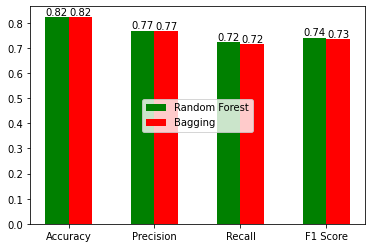

In [32]:
ind = np.arange(len(rf_scores))
width = 0.27

ax = plt.figure().add_subplot(111)
rects1 = ax.bar(ind-(width/2), rf_scores, width, color='g')
rects2 = ax.bar(ind+(width/2), bag_scores, width, color='r')

ax.set_xticks(ind)
ax.set_xticklabels(['Accuracy','Precision','Recall','F1 Score'])
ax.legend((rects1[0], rects2[0]), ('Random Forest', 'Bagging'),loc='center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%.2f'%h, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

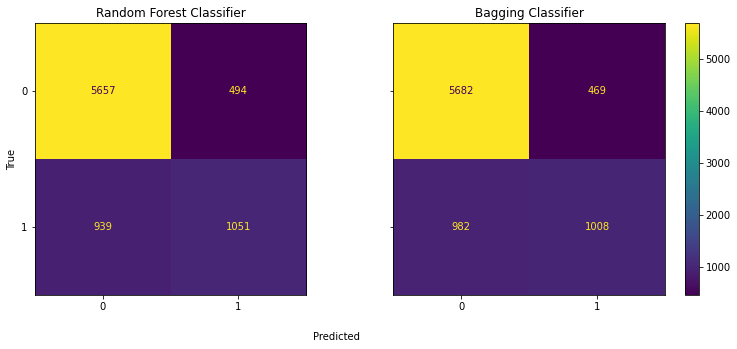

In [33]:
# Also check the values in confusion matrix.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

cm = confusion_matrix(y_test, y_rf, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(ax=axes[0])
disp.ax_.set_title('Random Forest Classifier')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('True')

cm = confusion_matrix(y_test, y_bag, labels=best_bag.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_bag.classes_)
disp.plot(ax=axes[1])
disp.ax_.set_title('Bagging Classifier')
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

f.text(0.5, 0, 'Predicted', ha='left')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()